In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import talib
import os
from utils import get_model_inputs, seed_everything, load_stock_data
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from models import MLP, Seq2Seq, RNNmodel

from joblib import dump, load
device = 'cuda'

In [2]:
full_data = pd.read_csv('ASX100.csv')
n_back = 20
n_forward = 5

seed_everything(1)
train_data, test_data, scalers = load_stock_data(full_data, n_back, test_date_split="2019-01-01", TI=True)
all_stocks = list(train_data.keys())
n_weeks = test_data[list(all_stocks)[0]].iloc[n_back:].shape[0]//5

input_data = {stock: get_model_inputs(stock, train_data, n_back, n_forward) for stock in all_stocks}

x = np.concatenate([input_data[stock][0] for stock in all_stocks], axis=0)
y = np.concatenate([input_data[stock][1] for stock in all_stocks], axis=0)

In [6]:
hidden_size = 150
mlp = MLP(n_back, hidden_size, n_forward)
mlp.load_model('./model_checkpoints/mlp.model')

input_dim = 10
hidden_dim = 2000
num_layers = 1 
gru = RNNmodel(input_dim, hidden_dim, num_layers, n_forward, 'gru', device=device)
gru.load_model('./model_checkpoints/gru_100_2000_7000_07.pt')


rnn_num_layers = 1
input_feature_len = 10
hidden_size = 2000
rnn_type = 'gru'
seq2seq = Seq2Seq(input_feature_len, hidden_size, rnn_num_layers, n_back, attn_dim=None, rnn_type=rnn_type, use_attn=False, device=device)
seq2seq.load_model('./model_checkpoints/seq2seq_90_2000_6000_005.pt')

rnn_num_layers = 1
input_feature_len = 10
hidden_size = 2000
rnn_type = 'gru'
seq2seq_attn = Seq2Seq(input_feature_len, hidden_size, rnn_num_layers, n_back, attn_dim=None, rnn_type=rnn_type, use_attn=True, device=device)
seq2seq_attn.load_model('./model_checkpoints/seq2seq_attn_15_2000_4500_005.pt')

all_models = dict(zip(['mlp', 'gru', 'seq2seq', 'seq2seq_attention'], [mlp, gru, seq2seq, seq2seq_attn]))

In [7]:
def model_predict(model_input, model_name, return_attn=False):
    if model_name == 'mlp':
        return all_models[model_name].predict(model_input.to_numpy().astype(np.float32).reshape(1,-1))[0]
    if model_name == 'gru' or model_name == 'lstm':
        return all_models[model_name].predict(torch.from_numpy(model_input.to_numpy().astype(np.float32)).unsqueeze(0).to(device)).cpu()[0].numpy()
    if model_name == 'seq2seq' or model_name == 'seq2seq_attention':
        if return_attn:
            predictions, attn_weights = all_models[model_name].predict(torch.from_numpy(model_input.to_numpy().astype(np.float32)).unsqueeze(0).to(device), 5, return_attn)
            predictions = predictions.cpu().numpy().flatten()
            return predictions, attn_weights    
        return all_models[model_name].predict(torch.from_numpy(model_input.to_numpy().astype(np.float32)).unsqueeze(0).to(device), 5).cpu().numpy().flatten()

def get_trade_data(all_models, selected_stocks, test_data = test_data):
    n_weeks = test_data[list(all_stocks)[0]].iloc[n_back:].shape[0]//5
    trading_data = {}

    for stock in all_stocks:
        trading_data[stock] = {}
        for week in range(n_weeks):
            current_price = test_data[stock].iloc[n_back+n_forward*week-1]['Close']*np.sqrt(scalers[stock].var_[3]) + scalers[stock].mean_[3]
            true_prices = test_data[stock].iloc[n_back+n_forward*week:n_back+n_forward*(week+1)]['Close']*np.sqrt(scalers[stock].var_[3]) + scalers[stock].mean_[3]
            model_input = test_data[stock].iloc[n_forward*week:n_back+n_forward*(week)]
            trading_data[stock][week] = {'past_prices':model_input['Close']*np.sqrt(scalers[stock].var_[3]) + scalers[stock].mean_[3], 
                                         'current_price': current_price, 'true_prices': true_prices}    
            for model_name in all_models:
                if stock in selected_stocks[model_name]:
                    trading_data[stock][week][model_name] = model_predict(model_input, model_name)*np.sqrt(scalers[stock].var_[3]) + scalers[stock].mean_[3]
                else: 
                    trading_data[stock][week][model_name] = None

    return trading_data 

In [8]:
def test_stock_predict(stock, all_models):
    result = {}
    for _model in all_models:
        predictions, true_values = all_models[_model].test_predict(stock, test_data, scalers, n_back, n_forward)
        result[_model] = predictions
    return result, true_values

#### remove stocks with low mape  

In [9]:
def MAPE(aa, bb):
    return np.mean(np.abs((aa - bb)/bb))
# val2_data = train_data
val2_data = {stock: train_data[stock].loc['2018-01-01':] for stock in all_stocks}
val2_input = {stock: get_model_inputs(stock, val2_data, n_back, n_forward) for stock in all_stocks}
val2_mape = {'stock': all_stocks}
for model_name in all_models:
    val2_mape[model_name] = []
    for stock in all_stocks:
        if model_name == 'mlp':
            train_pred = all_models[model_name].predict(val2_input[stock][0].reshape(val2_input[stock][0].shape[0], -1))
        if model_name == 'gru' or model_name == 'lstm':
            train_pred = all_models[model_name].predict(torch.from_numpy(val2_input[stock][0]).to(device)).cpu().numpy()
        if model_name == 'seq2seq' or model_name == 'seq2seq_attention':
            train_pred = all_models[model_name].predict(torch.from_numpy(val2_input[stock][0]).to(device), 5)[:,:,0].cpu().numpy()
            
        train_pred = train_pred*np.sqrt(scalers[stock].var_[3]) + scalers[stock].mean_[3]
        val2_mape[model_name].append(MAPE(train_pred, val2_input[stock][1]*np.sqrt(scalers[stock].var_[3]) + scalers[stock].mean_[3])) 
val2_mape = pd.DataFrame(val2_mape)

In [10]:
selected_stocks = {}
for model_name in all_models:
    selected_stocks[model_name] = val2_mape.sort_values(model_name).iloc[:80]['stock'].tolist()

In [33]:
for x in [sorted(set(all_stocks) - set(selected_stocks[model_name])) for model_name in all_models][0]:
    print(x, end=', ')

ALU, AMP, BPT, BSL, DMP, NEC, NXT, SAR, TPG, WOR, XRO, 

In [34]:
{model_name: len(selected_stocks[model_name]) for model_name in all_models}

{'mlp': 80, 'gru': 80, 'seq2seq': 80, 'seq2seq_attention': 80}

In [16]:
trade_test_data = test_data
trading_data = get_trade_data(all_models, selected_stocks, trade_test_data)

#### trading

In [35]:
trade_budget = 2000
trade_fee = 20
trading_results = {}
n_weeks = test_data[list(all_stocks)[0]].iloc[n_back:].shape[0]//5
# total_fee = 0
for week in range(n_weeks):
    trading_results[week] = {}
    for model_name in all_models:
        trading_results[week][model_name] = {}
        
for model_name in all_models:
    current_stocks = {stock:0 for stock in selected_stocks[model_name]}
    stock_returns = {stock: {'spend': 0, 'income': 0} for stock in selected_stocks[model_name]}
    total_return = 0
    total_spend = 0
    total_fee = 0
    for week in range(n_weeks):
        returns = pd.DataFrame({"stock": selected_stocks[model_name], "current_price": [trading_data[stock][week]['current_price'] for stock in selected_stocks[model_name]],
                                "next_mean_pred": [np.mean(trading_data[stock][week][model_name]) for stock in selected_stocks[model_name]],
                                "day5_pred": [trading_data[stock][week][model_name][-1] for stock in selected_stocks[model_name]],
                               "trend": [(np.diff(np.concatenate([[trading_data[stock][week]['current_price']], 
                                                                  trading_data[stock][week][model_name]])) > 0).mean() for stock in selected_stocks[model_name]]
                               })
    
        returns['return_pred'] = ((returns["day5_pred"] - returns["current_price"])/returns["current_price"])#/returns['score']**2
        
        returns = returns.sort_values("return_pred", ascending=False)

        to_sell = [x for x in returns[(returns['return_pred'] < 0) & (returns['trend'] <= 2/5)]['stock'].iloc[:].tolist() if current_stocks[x] > 0]
        to_buy = returns[(returns['return_pred'] > 0) & (returns['trend'] >= 3/5)]['stock'][:1].tolist()
        
        for stock in to_sell:
            _return = trading_data[stock][week]['current_price']*current_stocks[stock]
            total_return += _return
            current_stocks[stock] = 0
            total_fee += trade_fee
            stock_returns[stock]['income'] += _return
        
        for stock in to_buy:
            current_price = trading_data[stock][week]['current_price']
            n_buy = ((trade_budget)/len(to_buy))//current_price
            current_stocks[stock] += n_buy
            _spend = n_buy*current_price
            total_spend += _spend
            total_fee += trade_fee
            stock_returns[stock]['spend'] += _spend
        
        current_value = 0
        for stock in current_stocks:
            current_value += current_stocks[stock]*trading_data[stock][week]['current_price']
            
        trading_results[week][model_name] = {'returns': returns, 'to_sell': to_sell, 'to_buy': to_buy, 'current_stocks':current_stocks.copy(), 'stock_returns': stock_returns.copy(),
                                             'total_return': total_return, 'total_spend': total_spend, 'total_fee': total_fee, 'current_value': current_value, 
                                             'profit': total_return + current_value - total_spend - total_fee}
                
    for stock in current_stocks:
        if current_stocks[stock] > 0:
            _return = trading_data[stock][week]['current_price']*current_stocks[stock]
            total_return += _return
            current_stocks[stock] = 0  
            total_fee += trade_fee
            stock_returns[stock]['income'] += _return
            
    print(total_return, total_spend, total_return - total_fee - total_spend, ((total_return - total_fee - total_spend)/n_weeks),
          (total_return - total_fee - total_spend)/total_spend, ((total_return - total_fee - total_spend)/n_weeks)/trade_budget)

232016.24000000005 201627.4599999999 27508.780000000144 272.364158415843 0.1364336980687063 0.1361820792079215
236702.34999999998 201736.67899999995 32705.67100000003 323.8185247524756 0.16212059781156624 0.1619092623762378
250684.28 201724.49399999995 46739.78600000005 462.7701584158421 0.2317010942657269 0.23138507920792106
229222.25999999998 201694.75499999998 25067.505000000005 248.19311881188122 0.1242843672360246 0.12409655940594061


In [36]:
model_name = 'seq2seq'
stock_returns = trading_results[n_weeks - 1][model_name]['stock_returns']
stock_returns = {stock: stock_returns[stock] for stock in stock_returns if stock_returns[stock]['spend'] > 0}
for stock in stock_returns:
    stock_returns[stock]['profit'] = stock_returns[stock]['income'] - stock_returns[stock]['spend']
    stock_returns[stock]['ROI'] = 100* stock_returns[stock]['profit']/stock_returns[stock]['spend']
stock_returns = pd.DataFrame.from_dict(stock_returns).transpose()

In [37]:
stock_returns

,spend,income,profit,ROI
VCX,3998.195,5193.88,1195.685,29.905620
SCG,1998.625,3766.90,1768.275,88.474576
BOQ,45907.410,51316.56,5409.150,11.782738
OSH,61949.650,75811.68,13862.030,22.376285
SGR,5998.210,7361.14,1362.930,22.722279
BLD,3994.750,4226.28,231.530,5.795857
TLS,25975.290,29667.99,3692.700,14.216203
CGF,49904.060,71279.05,21374.990,42.832166
FLT,1998.304,2060.80,62.496,3.127452


Text(0, 0.5, 'Income')

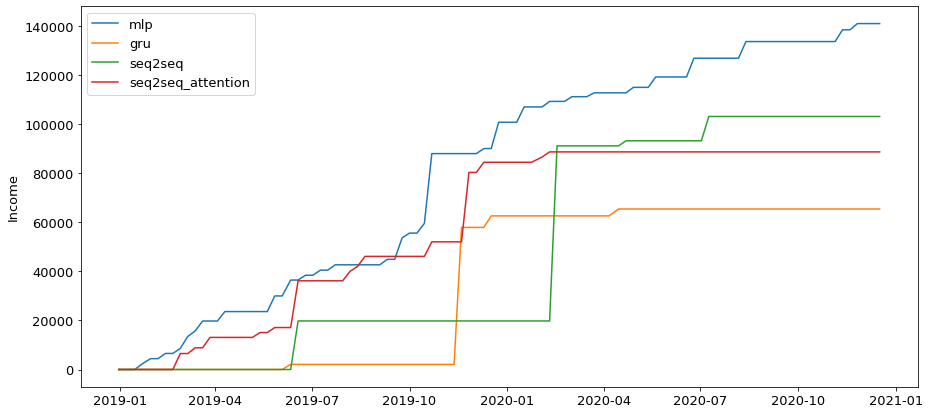

In [38]:
plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(1, 1, figsize=(15,7))
for i, model_name in enumerate(all_models):
    profit = ([trading_results[week][model_name]['total_return'] for week in range(n_weeks)])
    dates = pd.to_datetime([trading_data[all_stocks[0]][week]['past_prices'].index[-1] for week in range(n_weeks)])
    axs.plot(dates, profit, label=model_name)
axs.legend()
axs.set_ylabel('Income')

Text(0, 0.5, 'Portfolio Value')

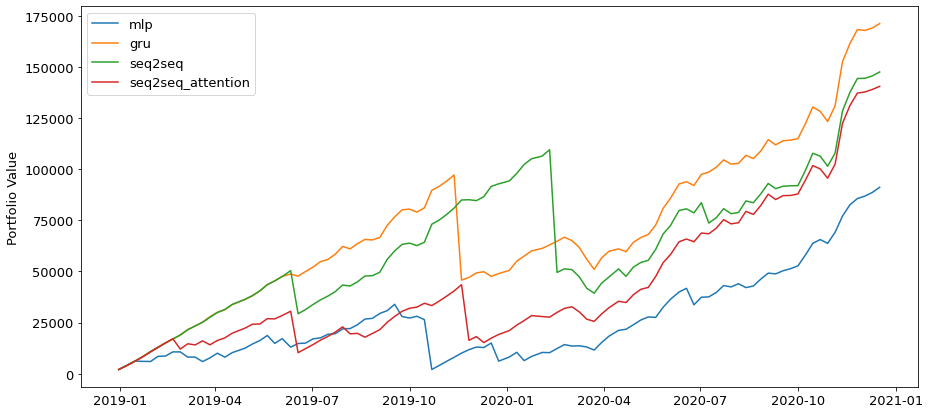

In [39]:
# plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(1, 1, figsize=(15,7))
for i, model_name in enumerate(all_models):
    profit = [trading_results[week][model_name]['current_value'] for week in range(n_weeks)]
    dates = pd.to_datetime([trading_data[all_stocks[0]][week]['past_prices'].index[-1] for week in range(n_weeks)])
    axs.plot(dates, profit, label=model_name)
axs.legend()
axs.set_ylabel('Portfolio Value')

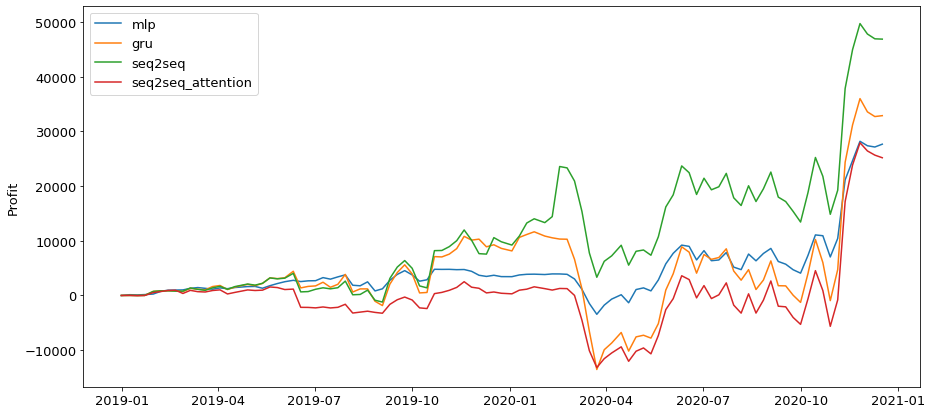

In [30]:
# plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(1, 1, figsize=(15,7))
for i, model_name in enumerate(all_models):
    profit = [trading_results[week][model_name]['profit'] for week in range(n_weeks)]
    dates = pd.to_datetime([trading_data[all_stocks[0]][week]['past_prices'].index[-1] for week in range(n_weeks)])
    axs.plot(dates, profit, label=model_name)
axs.set_ylabel('Profit')
axs.legend()

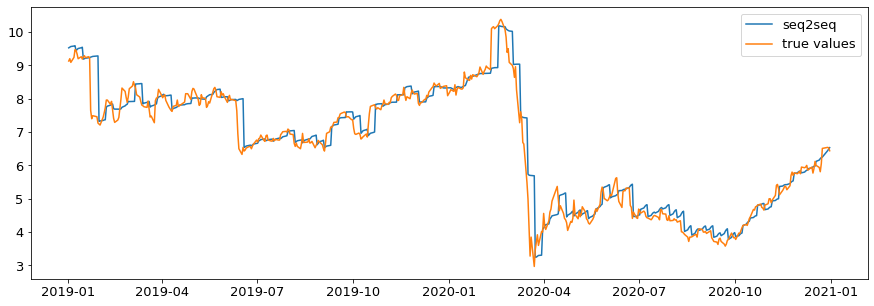

In [125]:
stock = 'CGF'
model_name = 'seq2seq'
plt.rcParams.update({'font.size': 13})
predictions, true_values = test_stock_predict(stock, all_models)
fig, axs = plt.subplots(figsize=(15,5))
axs.plot(pd.to_datetime(test_data[stock].index[n_back:]), predictions[model_name], label=model_name)
axs.plot(pd.to_datetime(test_data[stock].index[n_back:]), scalers[stock].inverse_transform(test_data[stock])[n_back:,3], label='true values')
axs.legend()

In [31]:
model_name = 'seq2seq'
for week in range(n_weeks):
    print(week, trading_data['TLS'][week]['past_prices'].index[-1], 'buy:',
          trading_results[week][model_name]['to_buy'], 'sell:',
          trading_results[week][model_name]['to_sell'], '\n',
         {x: trading_results[week][model_name]['current_stocks'][x] for x in trading_results[week][model_name]['current_stocks'] if trading_results[week][model_name]['current_stocks'][x] > 0})

0 2018-12-31 buy: ['TLS'] sell: [] 
 {'TLS': 701.0}
1 2019-01-08 buy: ['TLS'] sell: [] 
 {'TLS': 1390.0}
2 2019-01-15 buy: ['TLS'] sell: [] 
 {'TLS': 2079.0}
3 2019-01-22 buy: ['TLS'] sell: [] 
 {'TLS': 2763.0}
4 2019-01-30 buy: ['CGF'] sell: [] 
 {'TLS': 2763.0, 'CGF': 275.0}
5 2019-02-06 buy: ['CGF'] sell: [] 
 {'TLS': 2763.0, 'CGF': 533.0}
6 2019-02-13 buy: ['BLD'] sell: [] 
 {'BLD': 410.0, 'TLS': 2763.0, 'CGF': 533.0}
7 2019-02-20 buy: ['CGF'] sell: [] 
 {'BLD': 410.0, 'TLS': 2763.0, 'CGF': 792.0}
8 2019-02-27 buy: ['BOQ'] sell: [] 
 {'BOQ': 223.0, 'BLD': 410.0, 'TLS': 2763.0, 'CGF': 792.0}
9 2019-03-06 buy: ['TLS'] sell: [] 
 {'BOQ': 223.0, 'BLD': 410.0, 'TLS': 3391.0, 'CGF': 792.0}
10 2019-03-13 buy: ['CGF'] sell: [] 
 {'BOQ': 223.0, 'BLD': 410.0, 'TLS': 3391.0, 'CGF': 1048.0}
11 2019-03-20 buy: ['CGF'] sell: [] 
 {'BOQ': 223.0, 'BLD': 410.0, 'TLS': 3391.0, 'CGF': 1307.0}
12 2019-03-27 buy: ['BLD'] sell: [] 
 {'BOQ': 223.0, 'BLD': 859.0, 'TLS': 3391.0, 'CGF': 1307.0}
13 2019-04-0